## (深度)生成模型
假设数据集$X$服从一个未知的分布$p_{r}(x)$，若对数据集$X$的可观测样本$x^{(1)},...,x^{(n)}$来学习一个参数化的模型$p_{\theta}(x)$，使得$p_{\theta}(x)$尽可能的接近数据的真实分布$p_{r}(x)$（即两个分布的KL散度最小），当从模型$p_{\theta}(x)$中采样，就可生成新的数据样本。

#### 极大似然估计
对模型$p_{\theta}(x)$的未知量$\theta$，若模型的所有样本都是可观测的且，可使用最大似然估计得出未知参数$\theta$。但由于给定数据集$X$一般服从于高维空间中的复杂分布，很难直接建模$p_{\theta}(x)$

#### EM算法


#### 变分推断

### 通过变分或抽样的方法求似然函数的近似分布（VAE、MCMC、Boltzmann Machine）

### 避开求极大似然的隐式方法（GAN、WGAN）

### 对似然函数进行变形（Flow-based Model、Autoregressive Model）


## [DDPM](https://pypi.org/project/ddpm/)
先定义一个简单的前向过程，通过在逐个时间步将随机噪声添加到数据中的方式，将数据分布映射到高斯分布；生成器只需匹配前向过程对应逆过程的每一小步，即可还原数据分布。从原数据分布中采样，即可形成新的样本。

实现扩散模型的三个部分：
1、 Noise Scheduler：添加噪声的方法
2、 Neural Network（model）：预测图像中的噪声（反向过程）
3、 Timestep Encoding：编码当前时间步的方法

### 数据集

#### Stanford Cars Dataset

The Cars dataset contains 16,185 images of 196 classes of cars.
The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split.
Classes are typically at the level of Make, Model, Year, ex. 2012 Tesla Model S or 2012 BMW M3 coupe.

该数据集的训练样本没有固定的尺寸。


In [1]:
%matplotlib inline

import torch
import torchvision
import matplotlib.pyplot as plt

"""
加载数据集，注意这里没有对数据集进行transforms变化
"""

dataSet=torchvision.datasets.StanfordCars(
    # 数据集保存目录
    root='/mnt/37bdf30c-6275-4c74-8911-fe112425def1/dataset/DDPM',
    # 使用训练数据集
    split='train',
    # 下载
    download=True
)

len(dataSet)

8144

In [2]:
type(dataSet[0][0])

PIL.Image.Image

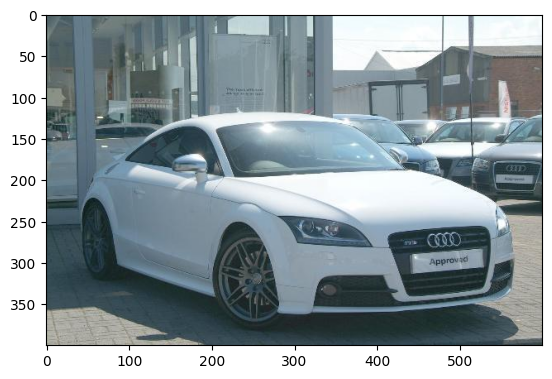

In [3]:
plt.imshow(dataSet[0][0])

In [4]:
"""
展示部分数据集
"""
def show_image(dataset,num_samples=20,cols=4):
    plt.figure(figsize=(15,15))
    for i,img in enumerate(dataSet):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols+1),cols,i+1)
        plt.imshow(img[0])

show_image(dataSet)

#### transform the data

In [5]:
from torchvision import transforms

# resolution to use
IMG_SIZE = 32

# 定义对训练数据集的变换方式
transform_train=transforms.Compose([
    # 重调整大小
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # 随机水平翻转
    transforms.RandomHorizontalFlip(),
    # 转为tensor类型
    transforms.ToTensor(),
    # convert values to be between [-1.0,  1.0]
    transforms.Lambda(lambda x: (x * 2) - 1)  # 归一化处理
])


# 变换后的训练数据集
dataset_transformed=torchvision.datasets.StanfordCars(
    root='/mnt/37bdf30c-6275-4c74-8911-fe112425def1/dataset/DDPM',  # 数据集保存目录
    split='train',  # 使用训练数据集
    transform=transform_train,
    download=True  # 下载
)

# 显示对象的所有属性
dir(dataset_transformed)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotations_mat_path',
 '_base_folder',
 '_check_exists',
 '_format_transform_repr',
 '_images_base_path',
 '_is_protocol',
 '_repr_indent',
 '_samples',
 '_split',
 'class_to_idx',
 'classes',
 'download',
 'extra_repr',
 'root',
 'target_transform',
 'transform',
 'transforms']

In [6]:
# 数据集第一个对象的第一个属性的形状
dataset_transformed[0][0].shape

torch.Size([3, 32, 32])

In [7]:
len(dataset_transformed[0][0].shape)

3

In [8]:
import numpy as np

"""
Reverse the transformation
"""

def tensor_to_pil(image):
    reverse_transforms = transforms.Compose([
        # back to [0, 1] for the values
        transforms.Lambda(lambda t: (t + 1) / 2),
        # CHW to HWC
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        # convert to range [0, 255]
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    return reverse_transforms(image)

### 前向加噪扩散过程
$$p(x_{t}|x_{0})=N(x_t;\sqrt{\bar{\alpha_{t}}}x_{0},(1-\bar{\alpha_{t}})I)$$

其中$\alpha_{t}=1-\beta_{t}\quad,\quad \bar{\alpha_{t}}=\prod_{i=1}^{t}\alpha_{i}\quad,\quad\epsilon~N(0,I)$
$ x_{t}=\sqrt{\bar{\alpha_{t}}}·x_{0}+(\sqrt{1-\bar{\alpha_{t}}})·\epsilon \quad \quad x_{0}=\frac{1}{\sqrt{\bar{\alpha_{t}}}}(x_{t}-\sqrt{1-\bar{\alpha_{t}}}·\epsilon_{t}$

In [9]:
"""
构造Noise Scheduler（Variance Scheduler），即添加噪声的策略
- 既不能每次添加较少的噪声使数据不能服从标准高斯分布；亦不能添加较大的噪声，使数据较早服从标准高斯分布
- 随着时间t的增加，在t时刻添加的噪声的均值（\sqrt{1-\beta_t}）越来越大，方差始终为\beta_t
- 本次使用线性增加\beta_t值的方式添加噪声
"""


def linear_beta_schedule(timesteps,start=0.0001,end=0.02):
    return torch.linspace(start,end,timesteps)

# 生成\beta的值
linear_beta_schedule(10)

tensor([1.0000e-04, 2.3111e-03, 4.5222e-03, 6.7333e-03, 8.9444e-03, 1.1156e-02,
        1.3367e-02, 1.5578e-02, 1.7789e-02, 2.0000e-02])

In [10]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


"""
预定义和预计算一些常量，这里计算出的值为向量，对应每个t时刻的取值。
"""

# Number of time steps in the diffusion process
T = 300

# \betas
betas = linear_beta_schedule(timesteps=T)

# Pre-calculations


alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, 0)
alphas_bar_sqrt = torch.sqrt(alphas_cumprod)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_cumprod)


# assert断言，在表达式为false时出错
assert alphas.shape==alphas_cumprod.shape==sqrt_alphas_cumprod.shape==sqrt_one_minus_alphas_cumprod.shape

betas.shape,type(betas)

(torch.Size([300]), torch.Tensor)

In [11]:
"""
前向加噪过程的第二种实现方式（可不用进行reshape常量）
"""

def forward_diffusion2(x_0, t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    noise = torch.randn_like(x_0)  # 生成一个正态分布的随机噪声
    alphas_t = alphas_bar_sqrt[t]  # 均值
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]  # 方差
    return (alphas_t * x_0 + alphas_1_m_t * noise).to(device), noise.to(device)  # 在x[0]的基础上添加噪声


In [12]:
"""
测试前向扩散过程
- 可以看到经过300步的加噪后，得到的噪声仍不是一个符合标准高斯分布的完美噪声。
"""

# take an image，这里选择第一个训练样本
image_0 = dataset_transformed[0][0]


# since plotting 'T' number of images is a bit much we decrease it
num_images = 10
# stepsize=33，即每33步绘制一次
stepsize = T // (num_images - 1)

# plot the image for different t's
fig, ax = plt.subplots(1, num_images, figsize=(20, 20), constrained_layout=True)

for ind in range(0, num_images):
    t = stepsize * ind

    # 将时间t转为tensor类型的tt，tt.shape=torch.Size([1])
    tt = torch.Tensor([t]).type(torch.int64)

    # 将样本放入cuda
    image_0=image_0.to(device)

    # 计算t时刻的x_t和噪声（可直接计算，不需要迭代）
    # image_t, _ = forward_diffusion1(image_0, tt)
    image_t, _ = forward_diffusion2(image_0, t)

    # 计算张量中所有元素的标准差与均值
    std, mean = torch.std_mean(image_t)
    print(f"t={t} ，std: {std:.2f} mean: {mean:.2f}")

    ax[ind].axis("off")
    ax[ind].set_title(f"t = {t}")
    ax[ind].imshow(tensor_to_pil(image_t.cpu()))


t=0 ，std: 0.44 mean: 0.03
t=33 ，std: 0.47 mean: 0.04
t=66 ，std: 0.56 mean: 0.03
t=99 ，std: 0.65 mean: 0.02
t=132 ，std: 0.73 mean: 0.00
t=165 ，std: 0.84 mean: 0.02
t=198 ，std: 0.89 mean: -0.01
t=231 ，std: 0.93 mean: 0.05
t=264 ，std: 0.96 mean: 0.03
t=297 ，std: 0.98 mean: 0.02


### 反向采样生成过程
$$q(x_{t-1}|x_{t})=N(x_{t-1};\frac{1}{\sqrt{\alpha_{t}}}(x_{t}-\frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}})·\epsilon_{t},(\frac{1-\bar{\alpha_{t-1}}}{1-\bar{\alpha_{t}}}·\beta_{t})^{2}I)$$
其中$x_{t-1} \sim N(x_{t-1};\frac{1}{\sqrt{\alpha_{t}}}(x_{t}-\frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}})·\epsilon_{\theta}(x_{t},t),(\frac{1-\bar{\alpha_{t-1}}} {1-\bar{\alpha_{t}}}·\beta_{t})^{2}I)$

$$
\begin{aligned}
\mathbf{x}_{t-1}
&= \mu_{\theta}(\mathbf{x}_t, t) + \sqrt{\tilde{\beta}_t}\epsilon \\
&= \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}} \epsilon_{\theta}(\mathbf{x}_t, t) \right) + \frac{1-\bar{\alpha_{t-1}}} {1-\bar{\alpha_{t}}}·\beta_{t}

\end{aligned}
$$

In [13]:
import torch.nn.functional as F

# pre-calculate some variables

# one_minus_alphas_bar_log = torch.log(1 - alphas_cumprod)

# \bar{\alpha_{t-1}}
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

# 后验分布的方差（常量）（一维向量）
posterior_variance = (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod) * betas

# 后验分布的均值的系数（常量）（一维向量）
sqrt_one_over_alphas = torch.sqrt(1.0 / alphas)

"""
单步采样
从x_t采样t时刻的重构值（Samples images from 'model' given image 'x' and time 't'）
输入图片x和时间t，返回模型预测的样本（返回t时刻的采样值）
"""
@torch.no_grad()
def sample_timestep(x, t, model):
    # 获取t时刻的beta值
    betas_t = betas[t]
    # betas_t = get_val_from_t(betas, t, x.shape)

    sqrt_one_minus_alphas_cumprod_t=sqrt_one_minus_alphas_cumprod[t]
    # sqrt_one_minus_alphas_cumprod_t = get_val_from_t(sqrt_one_minus_alphas_cumprod, t, x.shape)

    sqrt_one_over_alphas_t=sqrt_one_over_alphas[t]
    # sqrt_one_over_alphas_t = get_val_from_t(sqrt_one_over_alphas, t, x.shape)

    # t时刻后验分布的均值（模型预测）
    epsilon = model(x,t)

    posterior_mean_t = sqrt_one_over_alphas_t * (x - betas_t / sqrt_one_minus_alphas_cumprod_t * epsilon)

    # t时刻后验分布的方差（常量）

    posterior_variance_t = posterior_variance[t]

    # do not add noise if we are at t = 0
    noise = torch.randn_like(x) if t > 0 else 0.0

    return posterior_mean_t + torch.sqrt(posterior_variance_t) * noise



In [14]:
"""
从x_t恢复x_{t-1}、x_{t-2}...x_0

"""

@torch.no_grad()
def sample_images(model, num_samples = 5):
    """
    :param model: 训练好的模型
    :param num_samples: 保存的采样数
    :param images_per_sample:
    :return:
    """

    # tensor to store the results
    # num_images=10（对10张图片进行处理）
    images = torch.empty((num_samples, num_images, 1, 3, IMG_SIZE, IMG_SIZE))

    # 每stepsize（33）步采样一个结果
    stepsize = int(T/num_images)

    for sample in range(num_samples):

        # 生成x_t时刻的样本
        img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)

        # loop backwards
        for i in reversed(range(T)):
            img = sample_timestep(img, i, model)
            if i % stepsize == 0:
                # store sample image
                col = num_images - i // stepsize - 1
                images[sample, col] = img.detach().cpu()
    return images

### 损失函数
预测t时刻添加噪声的均值

$$
\begin{equation*}

    L_{t}=D_{KL}(p(x_{t+1}|x_{t})||q(x_{t}|x_{t+1}))\\

\end{equation*}
$$

![Training Loss](../../img/18_20.png)

![Training Loss](../../img/18_15.png)



In [ ]:
import torch.nn.functional as F

def get_loss(model, x_0, t):

    # get noisy image and the noise from the forward diffusion
    x_t, noise = forward_diffusion2(x_0, t)

    # predict the noise given noisy image and t
    noise_pred = model(x_t, t)

    return F.mse_loss(noise, noise_pred)

### 网络结构

In [86]:
"""
The architecture is a U-Net with baked-in attention and positional encoding.
"""
from functools import partial
import math
from tokenize import group

import torch
from torch import nn
from einops import reduce, rearrange


def l2norm(t):
    return F.normalize(t, dim = -1)


class UNet(nn.Module):
    def __init__(self, img_channels: int, init_dim: int, time_emb_dim: int, num_res: int = 4):
        """Creates a UNet

        Args:
            in_channels (int): number of images channels
            init_dim (int): number of output channels in the first layer
            time_emb_dim (int): time dimension size
            num_res (int, optional): Number of resolutions
        """
        super().__init__()

        # initial conv
        self.init_conv = nn.Conv2d(img_channels, init_dim, kernel_size=7, padding=3)

        # create list of the different dimensions
        dims = [init_dim, *map(lambda m: init_dim * m, [2**res for res in range(0, num_res)])]

        # create convenient list of tuples with input and output channels for each resolution
        in_out_dims = list(zip(dims[:-1], dims[1:]))

        # time embedding block
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(init_dim),
            nn.Linear(init_dim, time_emb_dim),
            nn.GELU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        # downsample
        self.down_layers = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out_dims):
            is_last = ind >= num_res - 1
            self.down_layers.append(
                nn.ModuleList([
                    ResNetBlock(dim_in, dim_in, time_emb_dim=time_emb_dim),
                    ResNetBlock(dim_in, dim_in, time_emb_dim=time_emb_dim),
                    Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                    Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1)
                ])
            )

        # middle block
        mid_dim = dims[-1]
        self.mid_block1 = ResNetBlock(mid_dim, mid_dim, time_emb_dim=time_emb_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = ResNetBlock(mid_dim, mid_dim, time_emb_dim=time_emb_dim)

        # upsample
        self.up_layers = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out_dims)):
            is_last = ind == num_res - 1
            self.up_layers.append(nn.ModuleList([
                ResNetBlock(dim_in + dim_out, dim_out, time_emb_dim=time_emb_dim),
                ResNetBlock(dim_in + dim_out, dim_out, time_emb_dim=time_emb_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else nn.Conv2d(dim_out, dim_in, 3, padding=1)
            ]))

        self.final_res_block = ResNetBlock(init_dim * 2, init_dim, time_emb_dim = time_emb_dim)
        self.final_conv = nn.Conv2d(init_dim, img_channels, 1)

    def forward(self, x, time):
        x = self.init_conv(x)
        r = x.clone()
        t = self.time_mlp(time)
        h = []
        for block1, block2, attn, downsample in self.down_layers:
            x = block1(x, t)
            h.append(x)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.up_layers:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)
            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = torch.cat((x, r), dim = 1)
        x = self.final_res_block(x, t)
        return self.final_conv(x)


class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        weight = self.weight
        mean = reduce(weight, 'o ... -> o 1 1 1', 'mean')
        var = reduce(weight, 'o ... -> o 1 1 1', partial(torch.var, unbiased = False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()
        return F.conv2d(x, normalized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class ResNetBlock(nn.Module):
    def __init__(self, dim_in, dim_out, time_emb_dim, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        )
        self.block1 = Block(dim_in, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim_in, dim_out, 1) if dim_in != dim_out else nn.Identity()

    def forward(self, x, t, time_emb = None):
        scale_shift = None
        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)
        h = self.block1(x, scale_shift = scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)


class Block(nn.Module):

    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)
        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift
        x = self.act(x)
        return x


def Upsample(dim_in, dim_out):

    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim_in, dim_out, 3, padding = 1)
    )

def Downsample(dim_in, dim_out = None):
    return nn.Conv2d(dim_in, dim_out, 4, 2, 1)

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)
        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)
        q = q * self.scale
        v = v / (h * w)
        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32, scale = 10):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)
        q, k = map(l2norm, (q, k))
        sim = torch.einsum('b h d i, b h d j -> b h i j', q, k) * self.scale
        attn = sim.softmax(dim = -1)
        out = torch.einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)



In [87]:
model = UNet(img_channels=3, init_dim=64, time_emb_dim=32)
print(f"Num params: {sum(p.numel() for p in model.parameters()):,}")

Num params: 34,366,147


In [88]:
model

UNet(
  (init_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
  (down_layers): ModuleList(
    (0): ModuleList(
      (0): ResNetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=32, out_features=128, bias=True)
        )
        (block1): Block(
          (proj): WeightStandardizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): WeightStandardizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (1): ResNetBlock(

### 训练

In [ ]:
import pytorch_lightning as pl
import torch
import torchvision

class LightningModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()

        # just wrap the model
        self.model = model

    def forward(self, x, t):
        return self.model(x, t)

    def training_step(self, batch, batch_idx):
        """Here we do the optimization"""

        # batch is in a list
        batch = batch[0]

        batch_size = batch.shape[0]

        # sample timesteps
        t = torch.randint(0, T, (batch_size,), device=self.device).long()

        # calc the loss
        loss = get_loss(self.model, batch, t, device=self.device)

        # log loss to tensorboard
        self.log("Loss", loss, on_step=True, on_epoch=True)

        return loss

    def on_train_epoch_end(self) -> None:
        """Function that runs when an epoch has been trained"""

        # every 10 epoch we sample images and log to tensorboard
        if self.trainer.current_epoch % 10 == 0:
            images = sample_images(model=self.model, device=self.device)
            img_h, img_w = images.shape[-2:]
            image_grid = torchvision.utils.make_grid(images.reshape(-1, 3, img_h, img_w), nrow=images.shape[1], normalize=True)
            self.logger.experiment.add_image('Model samples', image_grid, self.trainer.current_epoch)

        return super().on_epoch_end()

    def configure_optimizers(self):
        """Define our optimizer"""
        return torch.optim.Adam(model.parameters(), lr=0.0002)

In [ ]:
"""
We train for 1000 epochs with a batch size of 128 and using the Adam optimizer with a learning rate of 0.0002.
"""
from torch.utils.data import DataLoader, Subset

# Select a subset of the data in order to converge faster
dataset_transformed = Subset(dataset_transformed, range(0, 3000))

dataloader = DataLoader(
    dataset_transformed,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=24
)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    precision=32,
    max_epochs=1000,
    logger=True,
    log_every_n_steps=1
)

model = LightningModel(model)
trainer.fit(model, dataloader)


### 生成结果